In [6]:
!pip install -q findspark

In [7]:
from pyspark.sql import SparkSession
name= "Hack_Data"

spark= SparkSession.builder.appName(name).master("local[*]").getOrCreate()

In [8]:
spark

 ## Import data from Kaggle 

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("soheiltehranipour/sample-hack-data")

print("Path to dataset files:", path)

hack_df = spark.read.csv(path, header=True, inferSchema=True)

# Show the first few rows
hack_df.toPandas().head()

Path to dataset files: /Users/jaimecastro/.cache/kagglehub/datasets/soheiltehranipour/sample-hack-data/versions/1


,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
0,8,391.09,1,2.96,7,Slovenia,72.37
1,20,720.99,0,3.04,9,British Virgin Islands,69.08
2,31,356.32,1,3.71,8,Tokelau,70.58
3,2,228.08,1,2.48,8,Bolivia,70.80
4,20,408.50,0,3.57,8,Iraq,71.28


In [13]:
hack_df.printSchema()

root
 |-- Session_Connection_Time: integer (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [18]:
hack_df.toPandas().describe()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,30.008982,607.245269,0.511976,5.258503,10.838323,57.342395
std,14.088201,286.335932,0.500607,2.301907,3.063526,13.411063
min,1.000000,10.000000,0.000000,1.000000,6.000000,40.000000
25%,18.000000,372.200000,0.000000,3.122500,8.000000,44.127500
50%,31.000000,601.650000,1.000000,5.285000,10.500000,57.840000
75%,42.000000,843.702500,1.000000,7.400000,14.000000,70.577500
max,60.000000,1330.500000,1.000000,10.000000,15.000000,75.000000


# EDA

In [23]:
hack_df.select("Location").distinct().count()

181

# Data preprocessing

Pipelines: Vector assembler and data scaling


In [34]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

features=["Session_Connection_Time","Bytes Transferred","Kali_Trace_Used","Servers_Corrupted","Pages_Corrupted","WPM_Typing_Speed"]


assembler=VectorAssembler(inputCols=features, outputCol="features")

scaler= StandardScaler(inputCol="features", outputCol="scaled_features")

pipeline= Pipeline(stages=[assembler, scaler])

pipeline_model=pipeline.fit(hack_df)
processed_data=pipeline_model.transform(hack_df)
processed_data.toPandas().head()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed,features,scaled_features
0,8,391.09,1,2.96,7,Slovenia,72.37,"[8.0, 391.09, 1.0, 2.96, 7.0, 72.37]","[0.5678510846650524, 1.3658432518957642, 1.997..."
1,20,720.99,0,3.04,9,British Virgin Islands,69.08,"[20.0, 720.99, 0.0, 3.04, 9.0, 69.08]","[1.419627711662631, 2.517986463945197, 0.0, 1...."
2,31,356.32,1,3.71,8,Tokelau,70.58,"[31.0, 356.32, 1.0, 3.71, 8.0, 70.58]","[2.2004229530770782, 1.2444124562517545, 1.997..."
3,2,228.08,1,2.48,8,Bolivia,70.80,"[2.0, 228.08, 1.0, 2.48, 8.0, 70.8]","[0.1419627711662631, 0.7965469045293562, 1.997..."
4,20,408.50,0,3.57,8,Iraq,71.28,"[20.0, 408.5, 0.0, 3.57, 8.0, 71.28]","[1.419627711662631, 1.4266459597520256, 0.0, 1..."


# Kmeans modeling

In [36]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol='scaled_features', k=3)
model = kmeans.fit(processed_data)

24/11/26 23:32:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [38]:
print(kmeans.explainParams())

distanceMeasure: the distance measure. Supported options: 'euclidean' and 'cosine'. (default: euclidean)
featuresCol: features column name. (default: features, current: scaled_features)
initMode: The initialization algorithm. This can be either "random" to choose random points as initial cluster centers, or "k-means||" to use a parallel variant of k-means++ (default: k-means||)
initSteps: The number of steps for k-means|| initialization mode. Must be > 0. (default: 2)
k: The number of clusters to create. Must be > 1. (default: 2, current: 3)
maxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0. (default: 0.0)
maxIter: max number of iterations (>= 0). (default: 20)
predictionCol: prediction column name. (default: prediction)
seed: random seed. (default: -8

Cluster centers

In [37]:
model.clusterCenters()

[array([1.26023837, 1.31829808, 0.99280765, 1.36491885, 2.5625043 ,
        5.26676612]),
 array([3.05623261, 2.95754486, 1.99757683, 3.2079628 , 4.49941976,
        3.26738378]),
 array([2.93719177, 2.88492202, 0.        , 3.19938371, 4.52857793,
        3.30407351])]

# Clustering results

In [41]:
clusters = model.transform(processed_data)
clusters.toPandas().head()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed,features,scaled_features,prediction
0,8,391.09,1,2.96,7,Slovenia,72.37,"[8.0, 391.09, 1.0, 2.96, 7.0, 72.37]","[0.5678510846650524, 1.3658432518957642, 1.997...",0
1,20,720.99,0,3.04,9,British Virgin Islands,69.08,"[20.0, 720.99, 0.0, 3.04, 9.0, 69.08]","[1.419627711662631, 2.517986463945197, 0.0, 1....",0
2,31,356.32,1,3.71,8,Tokelau,70.58,"[31.0, 356.32, 1.0, 3.71, 8.0, 70.58]","[2.2004229530770782, 1.2444124562517545, 1.997...",0
3,2,228.08,1,2.48,8,Bolivia,70.80,"[2.0, 228.08, 1.0, 2.48, 8.0, 70.8]","[0.1419627711662631, 0.7965469045293562, 1.997...",0
4,20,408.50,0,3.57,8,Iraq,71.28,"[20.0, 408.5, 0.0, 3.57, 8.0, 71.28]","[1.419627711662631, 1.4266459597520256, 0.0, 1...",0


# Interpret the clustering results

In [42]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(metricName='silhouette', distanceMeasure='squaredEuclidean')

silhouette = evaluator.evaluate(clusters)
print("Silhouette = " + str(silhouette))

Silhouette = 0.30412315937808737


In [44]:
model.clusterCenters()

[array([1.26023837, 1.31829808, 0.99280765, 1.36491885, 2.5625043 ,
        5.26676612]),
 array([3.05623261, 2.95754486, 1.99757683, 3.2079628 , 4.49941976,
        3.26738378]),
 array([2.93719177, 2.88492202, 0.        , 3.19938371, 4.52857793,
        3.30407351])]

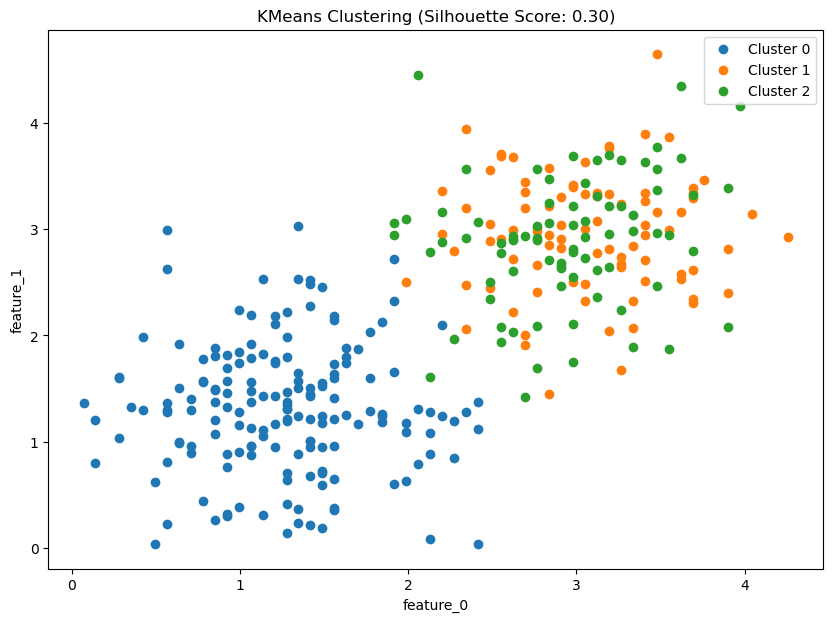

In [45]:
import matplotlib.pyplot as plt

# Extract predictions and select two features for plotting
clusters_pd = clusters.select("prediction", "scaled_features").toPandas()

# Convert the scaled_features vector into individual columns for plotting
import numpy as np
clusters_pd['scaled_features'] = clusters_pd['scaled_features'].apply(lambda x: np.array(x))
features_array = np.vstack(clusters_pd['scaled_features'])
clusters_pd = clusters_pd.drop(columns=['scaled_features'])

# Add the scaled features as individual columns
for i in range(features_array.shape[1]):
    clusters_pd[f"feature_{i}"] = features_array[:, i]

# Choose two features for plotting
feature_x = "feature_0"  # Replace with actual feature index
feature_y = "feature_1"  # Replace with actual feature index

# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster in np.unique(clusters_pd['prediction']):
    cluster_data = clusters_pd[clusters_pd['prediction'] == cluster]
    plt.scatter(cluster_data[feature_x], cluster_data[feature_y], label=f"Cluster {cluster}")

# Annotate the silhouette score in the plot title
plt.title(f"KMeans Clustering (Silhouette Score: {silhouette:.2f})")
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend()
plt.show()


Very likely the hacking was performed by 2 hackers, since 2 clusters are very similar and the third suspected hacker is highly differentiated from these 2 confirmed hackers. 